# Decision Trees

Decision trees are a popular method for solving classification and regression problems in machine learning. They are a type of supervised learning algorithm that learn to make decisions by constructing a tree-like model of decisions and their possible consequences.

In a decision tree, each node represents a decision, and each branch represents a possible outcome of that decision. The tree is constructed by recursively partitioning the data into subsets based on the values of the input features, with the goal of minimizing some measure of impurity or entropy. At each node, the algorithm selects the feature that best separates the data into the different classes, and splits the data accordingly.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
titles = pd.read_csv('../../preprocessing/titles_preprocessed.csv')
credits = pd.read_csv('../../preprocessing/credits_preprocessed.csv')

In [3]:
titles.head()

,id,title,type,description,release_year,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity
0,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926,78,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],0.0,tt0017925,8.2,89766.0,8.647
1,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940,92,"['comedy', 'drama', 'romance']",['US'],0.0,tt0032599,7.8,57835.0,11.270
2,tm19424,Detour,MOVIE,"The life of Al Roberts, a pianist in a New Yor...",1945,66,"['thriller', 'drama', 'crime']",['US'],0.0,tt0037638,7.3,17233.0,7.757
3,tm112005,Marihuana,MOVIE,A young girl named Burma attends a beach party...,1936,57,"['crime', 'drama']",['US'],0.0,tt0026683,4.0,864.0,3.748
4,tm22806,Intolerance: Love's Struggle Throughout the Ages,MOVIE,"The story of a poor young woman, separated by ...",1916,197,"['history', 'drama']",['US'],0.0,tt0006864,7.7,15242.0,9.412


In [4]:
credits.head()

,person_id,id,name,character,role
0,21174,tm19248,Buster Keaton,Johnny Gray,ACTOR
1,28713,tm19248,Marion Mack,Annabelle Lee,ACTOR
2,28714,tm19248,Glen Cavender,Captain Anderson,ACTOR
3,28715,tm19248,Jim Farley,General Thatcher,ACTOR
4,27348,tm19248,Frederick Vroom,A Southern General,ACTOR


In [5]:
# Checking for NaN values in titles
titles.isna().any().any() 

False

In [6]:
# Checking for NaN values in titles
credits.isna().any().any()

False

In [7]:
# Preprocessing the data

# Merge the titles with the actors/directors dataset
merged_titles_credits = pd.merge(credits, titles, on='id', how='left')

# Calculate the average IMDb score and TMDB popularity for each person_id
person_scores_df = merged_titles_credits.groupby('person_id').agg({'imdb_score': 'mean', 'release_year': 'mean', 'runtime': 'mean', 'seasons': 'mean'}).reset_index()
person_scores_df.rename(columns={'imdb_score': 'average_imdb_score', 'release_year': 'average_release_year', 'runtime': 'average_runtime', 'seasons': 'average_seasons'}, inplace=True)



# Merge the average IMDb scores with the actors/directors dataset
merged_df = pd.merge(credits, person_scores_df, on='person_id', how='left')

# Drop rows with missing average IMDb scores
merged_df.dropna(subset=['average_imdb_score'], inplace=True)

# # Drop rows with missing average TMDB popularity
merged_df.dropna(subset=['average_release_year'], inplace=True)
merged_df.dropna(subset=['average_runtime'], inplace=True)
merged_df.dropna(subset=['average_seasons'], inplace=True)

# IMDB score bins (0-4 - Low, 4-7 - Medium, 7-10 - High)
bins = [0, 4, 7, 10]
# Class labels
labels = ['Low-Rated', 'Medium-Rated', 'High-Rated']  

# Bin the IMDb scores into different ranges and assign labels
merged_df['imdb_score_bin'] = pd.cut(merged_df['average_imdb_score'], bins=bins, labels=labels)

merged_df

,person_id,id,name,character,role,average_imdb_score,average_release_year,average_runtime,average_seasons,imdb_score_bin
0,21174,tm19248,Buster Keaton,Johnny Gray,ACTOR,6.307692,1940.384615,77.615385,0.0,Medium-Rated
1,28713,tm19248,Marion Mack,Annabelle Lee,ACTOR,8.200000,1926.000000,78.000000,0.0,High-Rated
2,28714,tm19248,Glen Cavender,Captain Anderson,ACTOR,7.400000,1932.500000,73.000000,0.0,High-Rated
3,28715,tm19248,Jim Farley,General Thatcher,ACTOR,6.033333,1937.166667,74.333333,0.0,Medium-Rated
4,27348,tm19248,Frederick Vroom,A Southern General,ACTOR,8.200000,1926.000000,78.000000,0.0,High-Rated
...,...,...,...,...,...,...,...,...,...,...
38898,321201,tm1055776,Piotr Trzaskalski,director,DIRECTOR,6.046369,2021.000000,44.000000,0.0,Medium-Rated
38899,28071,tm975981,Cher,Herself,ACTOR,7.600000,2021.000000,46.000000,0.0,High-Rated
38900,399383,tm975981,Nick Daley,Narrator,ACTOR,7.600000,2021.000000,46.000000,0.0,High-Rated
38901,1032862,tm975981,Jonathan Finnigan,director,DIRECTOR,7.600000,2021.000000,46.000000,0.0,High-Rated


In [8]:
# Split the dataset into features and target
X = merged_df[['average_release_year', 'average_runtime', 'average_seasons']] # Features: TMDB popularity
Y = merged_df['imdb_score_bin'] # Target: IMDb score bin from merged dataset

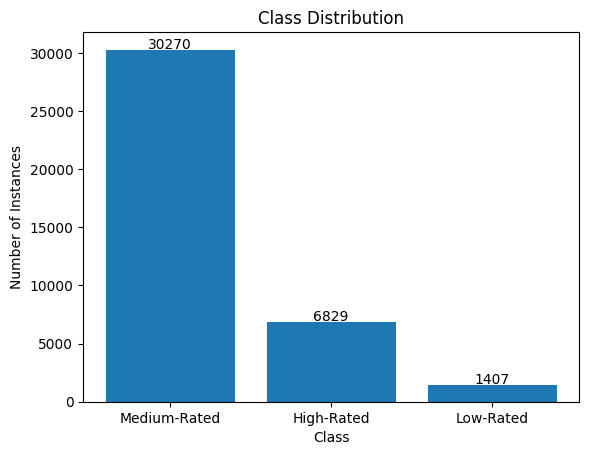

In [9]:
# Count the number of instances of each class in the target variable
class_counts = merged_df["imdb_score_bin"].value_counts()

# Create a bar chart of the class counts
plt.bar(class_counts.index, class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")

for i, count in enumerate(class_counts.values):
    plt.text(i, count+100, str(count), ha='center')

plt.show()

For our first attempt, we won't balance the classes. We'll just use a regular Decision Tree Classifier.

In [10]:
# Report function - copied from 
# https://github.com/MATF-istrazivanje-podataka-1/materijali_2022-2023/blob/main/05/Najblizi_susedi.ipynb

from termcolor import colored
from sklearn.metrics import classification_report

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")

In [11]:
# Importing the training and testing sets from the KNN file - fpr comparison later.
import pickle

# Loading the data from the file
with open('data.pkl', 'rb') as f:
    X_train, X_test, Y_train, Y_test = pickle.load(f)

In [12]:
# Initializing a decision tree classifier
dtc = DecisionTreeClassifier(random_state=41)

# Training the classifier on the training set
dtc.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=41)

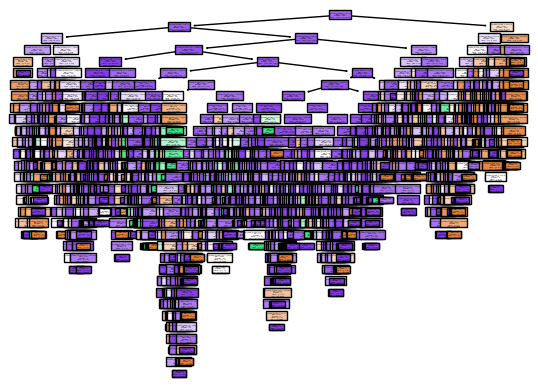

In [15]:
# Generating predictions on the test set
Y_pred = dtc.predict(X_test)

# Visualizing the decision tree
plt.figure()
plot_tree(dtc, feature_names=['average_release_year', 'average_runtime', 'average_seasons'], class_names=labels, filled=True)
plt.show()

In [16]:
report(dtc, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.95      0.97      0.96      5065
   Low-Rated       0.86      0.78      0.81      1071
Medium-Rated       0.98      0.98      0.98     22743

    accuracy                           0.97     28879
   macro avg       0.93      0.91      0.92     28879
weighted avg       0.97      0.97      0.97     28879

---------------------------------------------------------------------------------


### Classification report - train set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 95% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 98% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 86% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 97% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 98% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 78% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.96
* **Medium-Rated class** - 0.98
* **Low-Rated class** - 0.81

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 5065
* **Medium-Rated class** - 22743
* **Low-Rated class** - 1071


### <u> Accuracy: 97% </u>

In [17]:
report(dtc, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.92      0.94      0.93      1764
   Low-Rated       0.80      0.75      0.77       336
Medium-Rated       0.97      0.97      0.97      7527

    accuracy                           0.96      9627
   macro avg       0.90      0.89      0.89      9627
weighted avg       0.96      0.96      0.96      9627

---------------------------------------------------------------------------------


### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 92% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 97% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 80% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 94% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 97% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 75% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.93
* **Medium-Rated class** - 0.97
* **Low-Rated class** - 0.77

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1764
* **Medium-Rated class** - 7527
* **Low-Rated class** - 336


### <u> Accuracy: 96% </u>

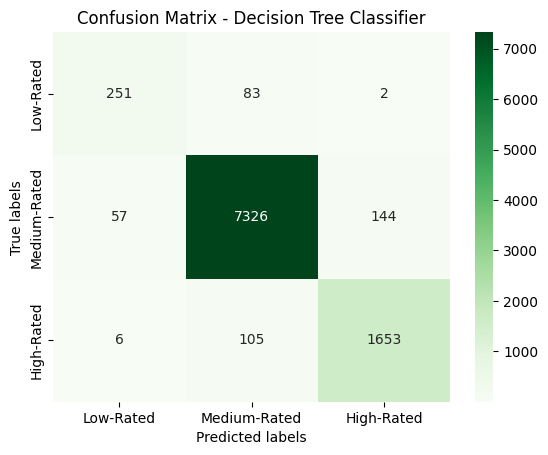

In [19]:
import seaborn as sns

# Creating a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Creating a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Decision Tree Classifier')

plt.show()

### Confusion matrix

##### For the Low-Rated class:
* 251 samples were correctly predicted as Low-Rated
* 83 samples were predicted as Medium-Rated but was actually Low-Rated
* 2 samples were predicted as High-Rated but were actually Low-Rated

##### For the Medium-Rated class:
* 57 samples were predicted as Low-Rated but were actually Medium-Rated
* 7326 samples were correctly predicted as Medium-Rated 
* 144 samples were predicted as High-Rated but were actually Medium-Rated 

##### For the High-Rated class:
* 6 samples were predicted as Low-Rated but were actually High-Rated
* 105 samples were predicted as Medium-Rated but were actually High-Rated
* 1653 samples were correctly predicted as High-Rated


# GridSearchCV 

Just like for KNN, we are going to use GridSearchCV to tune hyperparameters that result in the optimal performance of a model.

GridSearchCV exhaustively searches over all the possible hyperparameter combinations, and returns the combination that produces the best performance on the validation data. The performance metric used for evaluation can be specified by the user, and can vary depending on the problem at hand.

In [21]:
# gini: measures impurity by calculating the probability of misclassifying a randomly chosen data point in that node
# entropy: measures impurity by calculating the entropy of the class
# This model will try both criterions to decide on how to split the decision tree

# The grid search will also try different values of the maximum depth of the decision tree (from 3 to 29) and choose the optimal one
# Same goes for the number of features
from sklearn.model_selection import GridSearchCV
params =  {
    'criterion': ['gini', 'entropy'],
    'max_depth': [x for x in range(3, 30)],
    'max_features': [x for x in range(3, 40)]
}

# We are going to create two estimators. 

# The first estimator is going to balance our classes by
# automatically adjusting the weights of each class inversely proportional to the class frequencies in the input data. 
# This means that the algorithm will give more weight to the minority class and less weight to the majority class. 
GS_balanced_estimator = GridSearchCV(DecisionTreeClassifier(class_weight= 'balanced'), param_grid= params)

# The second estimator will not be balancing classes.
GS_estimator = GridSearchCV(DecisionTreeClassifier(), param_grid= params)

## First case: Decision Tree for Balanced Classes

DecisionTreeClassifier(class_weight='balanced') tells the classifier to automatically adjust the weights of each class inversely proportional to the class frequencies in the input data. 

This means that the algorithm will give more weight to the minority class and less weight to the majority class. 

In [22]:
GS_balanced_estimator.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20, 21, 22,
                                          23, 24, 25, 26, 27, 28, 29, 30, 31,
                                          32, ...]})

In [23]:
# Checking the best parameters for this decision tree
GS_balanced_estimator.best_params_

{'criterion': 'gini', 'max_depth': 27, 'max_features': 38}

In [25]:
# Checking the best score
GS_balanced_estimator.best_score_

0.9354201232746939

In [26]:
report(GS_balanced_estimator.best_estimator_, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.90      0.99      0.95      5065
   Low-Rated       0.57      1.00      0.73      1071
Medium-Rated       1.00      0.94      0.97     22743

    accuracy                           0.95     28879
   macro avg       0.82      0.98      0.88     28879
weighted avg       0.97      0.95      0.96     28879

---------------------------------------------------------------------------------


### Classification report - train set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 90% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 100% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 57% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 99% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 94% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 100% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.95
* **Medium-Rated class** - 0.97
* **Low-Rated class** - 0.73

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 5065
* **Medium-Rated class** - 22743
* **Low-Rated class** - 1071


### <u> Accuracy: 95% </u>

In [28]:
report(GS_balanced_estimator.best_estimator_, X_test, Y_test, "testing")

Classification report for model DecisionTreeClassifier on testing data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.86      0.96      0.91      1764
   Low-Rated       0.53      0.99      0.69       336
Medium-Rated       0.99      0.93      0.96      7527

    accuracy                           0.94      9627
   macro avg       0.80      0.96      0.85      9627
weighted avg       0.95      0.94      0.94      9627

---------------------------------------------------------------------------------


### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 86% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 99% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 53% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 96% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 93% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 99% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.91
* **Medium-Rated class** - 0.96
* **Low-Rated class** - 0.69

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1764
* **Medium-Rated class** - 7527
* **Low-Rated class** - 336


### <u> Accuracy: 94% </u>

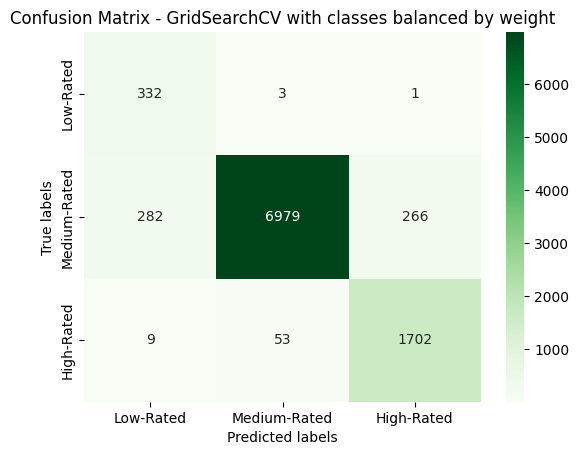

In [30]:
Y_pred = GS_balanced_estimator.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - GridSearchCV with classes balanced by weight')

plt.show()

These results are less precise than before using GridSearchCV with balanced classes. 

## Second case: Decision Tree for non-Balanced Classes

In [40]:
GS_estimator.fit(X_train, Y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                          14, 15, 16, 17, 18, 19, 20, 21, 22,
                                          23, 24, 25, 26, 27, 28, 29, 30, 31,
                                          32, ...]})

In [41]:
GS_estimator.best_params_

{'criterion': 'entropy', 'max_depth': 29, 'max_features': 38}

In [42]:
GS_estimator.best_score_

0.9532531628113345

In [44]:
report(GS_estimator.best_estimator_, X_train, Y_train)

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.95      0.97      0.96      5065
   Low-Rated       0.86      0.78      0.81      1071
Medium-Rated       0.98      0.98      0.98     22743

    accuracy                           0.97     28879
   macro avg       0.93      0.91      0.92     28879
weighted avg       0.97      0.97      0.97     28879

---------------------------------------------------------------------------------


### Classification report - train set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 95% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 98% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 86% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 97% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 98% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 78% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.96
* **Medium-Rated class** - 0.98
* **Low-Rated class** - 0.81

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 5065
* **Medium-Rated class** - 22743
* **Low-Rated class** - 1071


### <u> Accuracy: 97% </u>

In [36]:
report(GS_estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.91      0.94      0.93      1764
   Low-Rated       0.80      0.75      0.77       336
Medium-Rated       0.98      0.97      0.97      7527

    accuracy                           0.96      9627
   macro avg       0.90      0.89      0.89      9627
weighted avg       0.96      0.96      0.96      9627

---------------------------------------------------------------------------------


### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 91% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 98% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 80% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 94% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 97% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 75% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.93
* **Medium-Rated class** - 0.97
* **Low-Rated class** - 0.77

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1764
* **Medium-Rated class** - 7527
* **Low-Rated class** - 336


### <u> Accuracy: 96% </u>

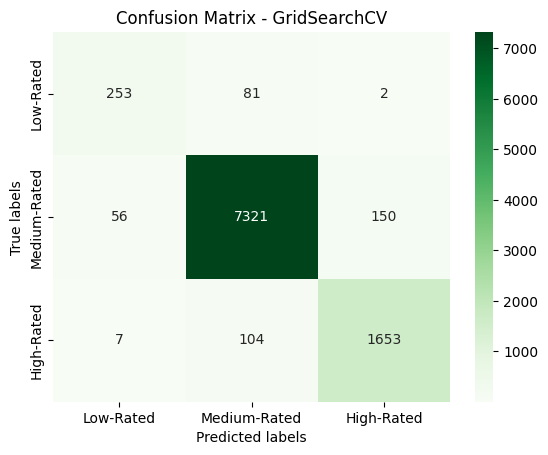

In [46]:
Y_pred = GS_estimator.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - GridSearchCV')

plt.show()

We can see that this method of balancing the classes is not very effective - the non-balanced estimator has higher precision and  the confusion matrix looks better as well.

So far, GridSearchCV without balancing classes has been the most precise estimator we used.

# Balancing classes using a Combination of over and under sampling - SMOTEENN


SMOTEEN is a combination of the Synthetic Minority Over-sampling Technique (SMOTE) and Edited Nearest Neighbors (ENN) algorithms, used for balancing imbalanced classes in classification problems.

SMOTE creates synthetic samples of the minority class by interpolating between existing samples. This helps to balance the class distribution and avoids overfitting to the majority class. However, it may also create noisy samples if the synthetic samples are generated too close to existing samples.

ENN removes samples from the majority class that are too close to minority class samples. This helps to remove noisy samples and improves the quality of the majority class samples. However, it may also remove informative samples and lead to underfitting.

SMOTEEN combines these two techniques by first applying SMOTE to oversample the minority class and then using ENN to clean up the resulting dataset by removing noisy samples from both the minority and majority classes that are close to each other. This helps to balance the classes and improve the quality of the dataset.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN

# Encoding target variable as categorical
Y_train = pd.Categorical(Y_train)

# Instantiating a SMOTEENN object
smoteenn = SMOTEENN(sampling_strategy='auto')

# Fiting the SMOTEENN object to the training data
X_train_resampled, Y_train_resampled = smoteenn.fit_resample(X_train, Y_train)

# Training the classifier on the resampled data
clf = DecisionTreeClassifier()
clf.fit(X_train_resampled, Y_train_resampled)

report(clf, X_train_resampled, Y_train_resampled)
report(clf, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       1.00      1.00      1.00     20439
   Low-Rated       1.00      1.00      1.00     14492
Medium-Rated       1.00      1.00      1.00     20192

    accuracy                           1.00     55123
   macro avg       1.00      1.00      1.00     55123
weighted avg       1.00      1.00      1.00     55123

---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.81      0.89      0.85      1764
   Low-Rated       0.53      0.76      0.62       336
Medium-Rated       0.97      0.92      0.94      7527

    accuracy   

### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 80% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 96% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 53% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 89% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 92% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 72% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.84
* **Medium-Rated class** - 0.94
* **Low-Rated class** - 0.61

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1764
* **Medium-Rated class** - 7527
* **Low-Rated class** - 336


### <u> Accuracy: 91% </u>

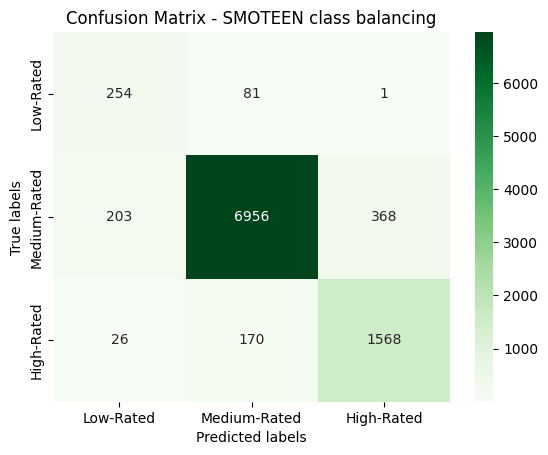

In [66]:
# Evaluating classifier on the testing data
Y_pred = clf.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SMOTEEN class balancing')

plt.show()

The precision of this method is about as good as the GridSearchCV one without the class balancing. 

# Random Forest Classifier

Random Forest Classifier is an ensemble learning algorithm used for classification problems. It builds multiple decision trees on random subsets of the dataset and then combines their predictions to make a final prediction.

The algorithm randomly selects a subset of features for each decision tree to reduce overfitting to the training data. It also uses bootstrap sampling to create multiple versions of the dataset, which allows it to capture more information from the dataset and reduce the variance of the model.

I'm trying this out because it can handle imbalanced classes by adjusting the weights of the classes, so it's often used with problems like these. 

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=41)

# Train the model on the training set
rfc.fit(X_train, Y_train)

report(rfc, X_test, Y_test, "test")

Classification report for model RandomForestClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.93      0.93      0.93      1764
   Low-Rated       0.82      0.74      0.78       336
Medium-Rated       0.97      0.98      0.98      7527

    accuracy                           0.96      9627
   macro avg       0.91      0.88      0.90      9627
weighted avg       0.96      0.96      0.96      9627

---------------------------------------------------------------------------------


### Classification report - test set

##### Precision: 
*true positives : (true positives + false positives)*

* **High-Rated class** - 93% of the predicted High-Rated instances were actually High-Rated.
* **Medium-Rated class** - 97% of the predicted Medium-Rated instances were actually Medium-Rated.
* **Low-Rated class** - 82% of the predicted Low-Rated instances were actually Low-Rated.

##### Recall
*true positives : (true positives + false negatives)*

* **High-Rated class** - The model correctly identified 93% of the actual High-Rated instances.
* **Medium-Rated class** - The model correctly identified 98% of the actual Medium-Rated instances.
* **Low-Rated class** - The model correctly identified 74% of the actual Low-Rated instances.

##### F1-score
*harmonic mean of precision and recall*

* **High-Rated class** - 0.93
* **Medium-Rated class** - 0.98
* **Low-Rated class** - 0.78

##### Support
*the number of samples or instances of each class in the test dataset*

* **High-Rated class** - 1764
* **Medium-Rated class** - 7527
* **Low-Rated class** - 336


### <u> Accuracy: 96% </u>

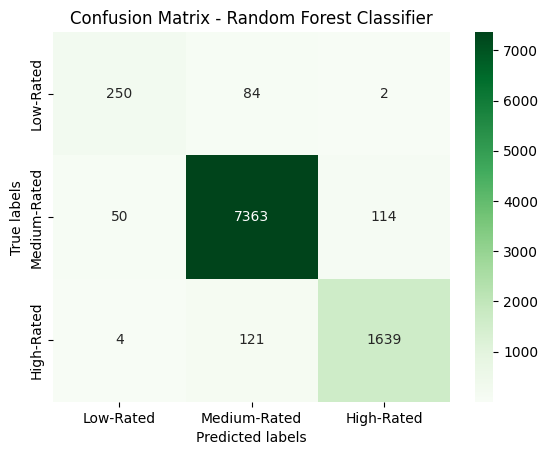

In [70]:
Y_pred = rfc.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest Classifier')

plt.show()

# Balanced Random Forest Classifier

Balanced Random Forest Classifier is a modification of Random Forest Classifier that is designed to handle imbalanced datasets. It works by adding a balancing step to the construction of each decision tree in the ensemble.

In a standard Random Forest Classifier, each decision tree is constructed on a bootstrap sample of the original dataset, which can result in a biased sample if the dataset is imbalanced. However, in Balanced Random Forest Classifier, each decision tree is constructed on a balanced subsample of the original dataset. This balancing step involves random undersampling of the majority class and random oversampling of the minority class to create a balanced dataset for each decision tree.

Balanced Random Forest Classifier can be useful when the dataset is highly imbalanced, and the minority class is of particular interest. It can also help to prevent overfitting and improve the accuracy of the model by reducing the variance of the decision trees.

In [73]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(max_depth=6, random_state=42, max_samples=20)

brfc.fit(X_train, Y_train)

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\Mila\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\User

BalancedRandomForestClassifier(max_depth=6, max_samples=20, random_state=42)

In [74]:
report(brfc, X_train, Y_train)

Classification report for model BalancedRandomForestClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.42      0.63      0.50      5065
   Low-Rated       0.10      0.74      0.18      1071
Medium-Rated       0.91      0.54      0.67     22743

    accuracy                           0.56     28879
   macro avg       0.48      0.64      0.45     28879
weighted avg       0.79      0.56      0.62     28879

---------------------------------------------------------------------------------


In [75]:
report(brfc, X_test, Y_test)

Classification report for model BalancedRandomForestClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

  High-Rated       0.43      0.61      0.50      1764
   Low-Rated       0.09      0.72      0.17       336
Medium-Rated       0.90      0.54      0.67      7527

    accuracy                           0.56      9627
   macro avg       0.47      0.62      0.45      9627
weighted avg       0.78      0.56      0.62      9627

---------------------------------------------------------------------------------


This is by far the least precise model.

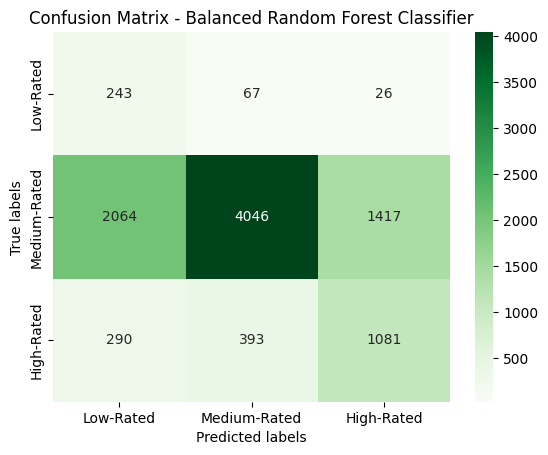

In [77]:
Y_pred = brfc.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(Y_test, Y_pred, labels=labels)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Balanced Random Forest Classifier')

plt.show()

Conclusion: if we are looking for precision, we should either choose GridSearchCV without class balancing, or the Random Forest Classifier.